# Assignment 4 - MNIST Digits
## CS156, Prof. Sterne
## Oscar Engelbrektson, Fall 2019

We are going to revisit the MNIST dataset from the first weekly assignment.

Load the entire MNIST digit dataset: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/ "http://yann.lecun.com/exdb/mnist/"%29. You will probably find the following gist useful: https://gist.github.com/MFathirIrhas/f24d61d134b014da029a.
Choose two digit classes (e.g 7s and 3s) from the training data, and plot some of the examples.

Train a support vector classifier using each of the following kernels:
1. Linear
2. Poly
3. RBF

(If you encounter any issues with training time or memory issues, then you may use a reduced dataset, but carefully detail how you reduced the dataset.)

Report your training times on the dataset for the different kernels.

Report your error rates on the testing dataset for the different kernels.

In [2]:
#Loading the dataset
import os
import struct
from array import array as pyarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

## Loading 2 digits from the MNIST dataset

In [3]:
#Function from https://gist.github.com/MFathirIrhas/f24d61d134b014da029a
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    #Gets files from computer
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
        
    #Unpack lables from file
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()
    
    #Unpack images from file
    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()
    
    #Represent images and lables appropriately structured numpyarrays
    #And match them up such that the label at index i in labels corresponds 
    #to image i in images
    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = np.zeros((N, rows, cols), dtype="uint8")
    labels = np.zeros((N, 1), dtype="int8")
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return np.array(images), np.array(labels)

In [4]:
def load_2digits(a, b, subset=False):
    '''
    Returns arrays X_train, y_train, X_test, y_test
    Xs with images and ys with labels
    for two digits a, b in MNIST
    Subset redeuces training data by extracting a random subset of size subset
    '''
    #Load entire data set
    X_train, y_train = load_mnist(dataset="training", path="/Users/oscarengelbrektson/Downloads/")
    X_test, y_test = load_mnist(dataset="testing", path="/Users/oscarengelbrektson/Downloads/")
    
    
    #Extract desired subset
    train_indices = np.where((y_train == a) | (y_train == b))[0]
    if subset is not False:
            random.seed(42)
            train_indices = random.sample(list(train_indices), subset)
    y_train = y_train[train_indices]
    X_train = X_train[train_indices]
    
    #Print some images
    fig, ax = plt.subplots(nrows=3, ncols=3, constrained_layout=True)
    fig.tight_layout(h_pad=2)
    i = 0
    for col in ax.flat:
        index = random.randint(0, len(X_train))
        plt.gray()
        col.matshow(X_train[index])
        col.set_title(y_train[index])
        i+=1
    plt.show()
    
    #Flatten every image
    X_train = np.array([X_train[i].flatten() for i in range(len(X_train))])
    
    #Repeating for the testset
    test_indices = np.where((y_test == a) | (y_test == b))[0]
    y_test = y_test[test_indices]
    X_test = X_test[test_indices]
    
    
    #Flatten every image
    X_test = np.array([X_test[i].flatten() for i in range(len(X_test))])
    
    return X_train, y_train, X_test, y_test

The subset argument allows the user to reduce the size of the training set. It does so 
The reason one might want to do this is reduce memory and computation needed to train models, particularly more costly techniques like gridsearch cross validation.
We keep the entire test set always because it is standardized so that different models, made by different people, can be benchmarked against it and compared (also, it does not pose the same computational/memory problems as the training set as it is both much smaller and only ever used to test the model). 

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


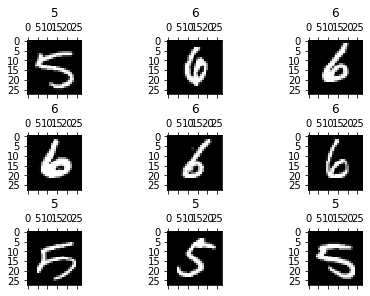

In [5]:
#Load digits 5, 6 from MNIST dataset, make training set size 300
#Pictures are 28x28 pixels.
#For modelling we flatten the pictures into a 1-d array of 28*28=784 pixels
X_train, y_train, X_test, y_test = load_2digits(5, 6, subset=1000)

In [7]:
X_train[0].shape

(784,)

In [218]:
#shape of train and test objects
print(X_train.shape)
print(X_test.shape)

(1000, 784)
(1850, 784)


In [219]:
# shape of new y objects
print(y_train.shape)
print(y_test.shape)

(1000,)
(1850,)


# Fitting SVMs
Our aim is to accurately clasify whether a digit image is of a 5 or a 6, given an array representing the image of the digit. We have no preferences as to which types of error are more or less desirable, we simply want to be right as often as possible. Consequently, I have decided progress towards this objective is best captured by classification accuracy.

For each kernel, prior to fitting the model on all the training data, cross validation will be used to select hyperparameter settings. The parameter settings that maximise the average validation set accuracy across the five folds will be selected.

In [296]:
#Support Vector Machines
from sklearn import svm

#Model selection and evaluation
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import time

# Linear SVM

All SVMs have the hyperparameter C in common. Conceptually, it specifies a tradeoff between training set classification accuracy and model smoothness. Large values of C means that the model will place larger value on correctly classifying all training data, whilst lower values of C means that keeping the decision surface smooth (i.e. not change much for small variations in X). It can thus be thought of as a regularization parameter. As such, selecting appropriate values for these hyperparameters is very important for model performance (scikit-learn.org, n.d). Cross validation is performed on a wide range of values for C, from e-8 to e8 with one order or magnitude between each value.

The cross validation procudure will use 5-folds, with a 80/20 train-validation data split each iteration. 

In [221]:
#Selecting parameters to try in CV
c_range = [10**x for x in range(-8, 9)]
scores_list = []

#for every value of C, perform cross validation 
#and record the average validation set accuracy
for c in c_range:
    model = svm.LinearSVC(C=c, max_iter=10000)
    cv_results = cross_validate(model, X_train, y_train,
                            scoring=['accuracy'], cv=5)
    
    #Store average accuracy accross the five splits
    scores_list.append(np.mean(cv_results['test_accuracy']))

The best parameters are C=1e-07 with a accuracy of 0.981


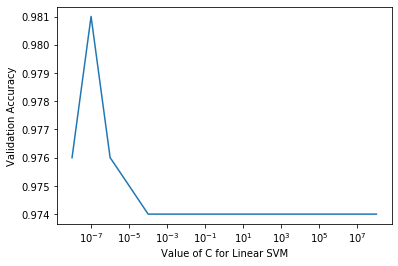

In [304]:
#Visualize CV results for the different Cs
print("The best parameters are C=%s with a accuracy of %0.3f"
      % (c_range[np.argmax(scores_list)], max(scores_list)))

plt.semilogx(c_range,scores_list)
plt.xlabel('Value of C for Linear SVM')
plt.ylabel('Validation Accuracy')
plt.show()

Fitting the model with the best hyperparameters from CV and training on all the data, then evaluating classification accuracy on the test set

In [223]:
def testing_accuracy(model):
    '''
    Trains model on entire training set
    Returns testset classification accuracy and training time in microseconds
    '''
    #Fitting the model on the entire training set and taking the time
    start = time.time()
    model.fit(X_train,y_train)
    end=time.time()
    train_time = 1000*(end-start)

    #Making prediction on the unseen test data
    y_pred=model.predict(X_test)
    return accuracy_score(y_test,y_pred), train_time

In [283]:
print("The test set classification accuracy is %0.3f and it took %0.2f microseconds to train the model"
      % testing_accuracy(svm.LinearSVC(C=10**-7)))

The test set classification accuracy is 0.971 and it took 8.58 microseconds to train the model


# SVM with Poly kernel
An SVM with a polynomial kernel has, in addition to C, one additional hyperparameter, degree, which specifies the degree of the polynomial. Higher order polynomials are more flexible and can thus generate decision boundaries which misclassify fewer of the training data. However, too high degree of the polynomial often results in too flexible decision boundaries which overfit the data, resulting in poor testset performance (high variance). Conversely, too low degree of the polynomial may result in underfitting the data (high bias). It is thus important to select a degree that offers a good tradeoff between bias and variance.

We use Gridsearch cross validation to examine the performance of each degree, c pair. Here also, we use exponential spacing between each step of c, between 1e-10 and 1e4 (the search was expanded as the optimal result was on the edge at 1e-0.7, to make sure more extreme values were not better). As degree=1 is just a linear kernel (already fitted above) I tried degrees 2 through 7.

In [300]:
#Selecting parameters to try in Grid CV
C_range = [10**x for x in range(-10, 4)]
degree_range = [x for x in range(2, 8)]
parameters = {'degree':degree_range, 
              'C':C_range}

#Make SVM
svc = svm.SVC(kernel="poly")

#Define data splitting procedure:
#5 folds, 80/20 train-validation split in each
cv = StratifiedKFold(n_splits=5, random_state=42)
#Try each parameter combination and store resuls
grid = GridSearchCV(svc, parameters, cv=5)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1e-07, 'degree': 2} with a score of 0.982


Fitting the model with the best hyperparameters from CV and training on all the data, then evaluating classification accuracy on the test set

In [301]:
print("The test set classification accuracy is %0.3f and it took %0.1f microseconds to train the model"
      % testing_accuracy(svm.SVC(kernel="poly", degree=2, C=10**-7)))

The test set classification accuracy is 0.981 and it took 137.5 microseconds to train the model


# SVM with RBF kernel
An SVM with a RBF kernel has, in addition to C, one additional hyperparameter, gamma, which how close away data  have to be to affect the decision boundary at a point. Higher values of gamma mean that only data closeby are taken into consideration, resulting in a more flexible decision boundary. Conversely, smaller values of gamma mean data from a wider range affect the decision boundary at each point, resulting in a smoother decision function. Consequently, gamma can be thought of as a parameter that guides the smoothness of the decision boundary. As is often the case, choosing the right value for gamma is about determining the appropriate bias-variance trade-off (for the same reasons as explained in poly kernel) (scikit-learn.org, n.d.)

Similar to the poly kernel procedure, we use Gridsearch cross validation to examine the performance of each gamma, c pair. We use exponential spacing between each step of gamma, between 1e-8 and 1e4. Same as for c.

In [302]:
#Same procedure as SVM kernel, only difference in model and parameters
#Selecting parameters to try in Grid CV
C_range = gamma_range = [10**x for x in range(-8, 4)]
parameters = {'gamma':gamma_range, 
              'C':C_range}

#Make SVM
svc = svm.SVC(kernel="rbf")

#Perform CV
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=42)
grid = GridSearchCV(svc, parameters, cv=5)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1, 'gamma': 1e-07} with a score of 0.983


In [303]:
print("The test set classification accuracy is %0.3f and it took %0.1f microseconds to train the model"
    % testing_accuracy(svm.SVC(kernel="rbf", gamma=10**-7, C=1)))

The test set classification accuracy is 0.979 and it took 173.8 microseconds to train the model


# Summarizing results

The below table summarizes the results for the different SVMs trained in the previous section.


| Kernel | Hyperparameters | Training Time (microseconds) | Training Accuracy | Test Accuracy | 
| --- | --- | --- | --- | --- | 
| Linear | C=1e-07 | 9 | 0.981 | 0.971 | 
| Poly | C=1e-08, degree=2 | 138 | 0.982 | 0.981 | 
| RBF | C=1, gamma=1e-06 |165 | 0.983 | 0.979 | 

In terms of accuracy, all models performed well in the 0.97-0.98 range and the relative differences are thus small. All have basically the same training set error (0.981, 0.982, 0.983), what separates them is their ability to transfer classification accuracy onto unseen data (the test set). Here linear SVM does the worst, dropping one percentage point in classification accuracy on the test set (which does not seem particularly extreme, to be fair), whilst the polynomial kernel does the best dropping only one tenth of a percentage point (which means test accuarcy is basically the same as the training set).

In terms of training time, polynomial and rbf are similar–with poly being slightly faster, ~15% on the training set with N=1000. Linear SVM is one order of magnitude faster, training in 9 microseconds.

In conclusion, the RBF kernel is strictly dominated in these results. Choosing a model then, comes down to a tradeoff between the training time advantages offered by the linear kernel and test accuracy offered by the poly kernel. Which is best depends on the context, for example, the cross validation procedure for the poly kernel would take prohibitively long on my computer if I had used the entire dataset (it has the addtional disadvantage of requiring 2 hyperparameters taking requiring the square as many models to be evaluated, at the already slower training time, as compared to the linear model). Whereas, if we are in a context where every last decimal of accuracy matters or computation is less of an issue, poly is the way to go for this problem.

As an aside, it is interesting to consider what the optimal hyperparameters can tell us about the model/the dataset. It seems that a good decision boundary for this classification problem needs to be quite smooth, almost linear. For example, for the polynomial c is small and the polynomial is of degree 2 It would thus seem that the polynomial chose the solution that was as close to being linear as possible, yet that slight non-linearity improved performance. In the case of the RBF kernel the gamma is small (gamma=1e-06)–meaning that data froma wider range is taken into account, resulting in a smoother decision boundary– whilst C is large relative to the other models. We can thus infer that the gamma is doing the main work to prevent overfitting, by keeping the decision boundary sufficiently smooth to generalize to the test set.

### Resources:    
mfathirirhas. (2018). LoadMNIST.py.

    Retrieved
    https://gist.github.com/MFathirIrhas/f24d61d134b014da029a
    
    
LeCunn, Y. (n.d.) THE MNIST DATABASE of handwritten digits.
    
    Retrieved
    https://gist.github.com/MFathirIrhas/f24d61d134b014da029a
    
    
scikit-learn.org (n.d). scikit-learn v0.21.3 documentation: 1.4. Support Vector Machines.

    Retrieved
    https://scikit-learn.org/stable/modules/svm.html#svm-kernels